# Caffe2 Basic Concepts - Operators & Nets

在這個tutorial 我們會介紹一些 caffe2的基本原理 : op 跟 net 怎麼寫

首先,
import caffe2 的 `core`, `workspace` , 這是你最經常會需要的

如果你想要操作 caffe2 所建立出來的  protocol buffers , 你會需要 import `caffe2_pd2` from `caffe2.proto`




In [2]:
# We'll also import a few standard python libraries
from matplotlib import pyplot
import numpy as np
import time

# These are the droids you are looking for.
from caffe2.python import core, workspace
from caffe2.proto import caffe2_pb2

# Let's show all plots inline.
%matplotlib inline

如果你看到 caffe2 說你沒有 GPU support, 那就代表你只能用CPU

別被嚇傻了, CPU 跑起來也不會有任何問題

## Workspaces

讓我們先介紹一下 workspace, 這是所有data 住的地方

如果你很熟悉 Matlab, workspace 就由 你所 `創造、並存在記憶體的 blob` 組成

現在將 blob 考慮成一個 n-dimensional tensor (就像 numpy 的 ndarray), 但他是 contiguous (memory allocation)

等等我們會展示給你看 其實blob是一個 類型指標, 可以儲存任何類型的 c++ 物件, tensor 只是其中最常見的一種

讓我們看一下 interface 長怎樣：

`Blobs()` 將所有的blobs 秀出來
`HasBlob()` 拉出指定的blob from workspace, 現在裡面什麼都沒有


In [3]:
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
print("Workspace has blob 'X'? {}".format(workspace.HasBlob("X")))

Current blobs in the workspace: []
Workspace has blob 'X'? False


讓我們用 `FeedBlob()` 塞個東西到 workspace 

In [4]:
X = np.random.randn(2, 3).astype(np.float32)
print("Generated X from numpy:\n{}".format(X))
workspace.FeedBlob("X", X)

Generated X from numpy:
[[-0.91712683  0.36256164 -0.09739182]
 [ 0.56679547  1.40343189 -0.54806918]]


True

現在我們可以看看blobs在 workspace 中長怎樣

In [5]:
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
print("Workspace has blob 'X'? {}".format(workspace.HasBlob("X")))
print("Fetched X:\n{}".format(workspace.FetchBlob("X")))

Current blobs in the workspace: [u'X']
Workspace has blob 'X'? True
Fetched X:
[[-0.91712683  0.36256164 -0.09739182]
 [ 0.56679547  1.40343189 -0.54806918]]


挖, 塞進去惹, 好棒棒

我們驗證一下他們一不一樣

In [6]:
np.testing.assert_array_equal(X, workspace.FetchBlob("X"))

一樣呢, 真棒

接著 我們如果你query一個 不存在的傢伙 會怎麼樣

In [7]:
try:
    workspace.FetchBlob("invincible_pink_unicorn")
except RuntimeError as err:
    print(err)

[enforce fail at pybind_state.cc:173] ws->HasBlob(name). Can't find blob: invincible_pink_unicorn 


先跟你介紹個你可能不會馬上用到的功能: multiple workspaces

在python裡, 你可以有 多個workspaces 且可以輕易切換

不同workspace 內的Blob 是不共通的, 使用 `CurrentWorkspace` 可以知道你在哪個

讓我們使用 `SwitchWorkSpace` 切換到 `gutentag` workspace, 如果該workspace不存在 會自動創新的.


In [8]:
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

# Switch the workspace. The second argument "True" means creating 
# the workspace if it is missing.
workspace.SwitchWorkspace("gutentag", True)

# Let's print the current workspace. Note that there is nothing in the
# workspace yet.
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

Current workspace: default
Current blobs in the workspace: [u'X']
Current workspace: gutentag
Current blobs in the workspace: []


好惹讓我們切回 default

In [9]:
workspace.SwitchWorkspace("default")
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

Current workspace: default
Current blobs in the workspace: [u'X']


最後 `ResetWorkspace` 會將目前的 workspace 裡的所有東西清空

In [10]:
workspace.ResetWorkspace()

True

##### Operators
Operators in Caffe2 像是一種 function .
從 C++ 的角度, 他們 都會由相同的 interface 導出, 而且會使用 `type`來註冊, 所以我們可以在runtime 時 call different opertator.
operators 的 Interface 於 `caff2/proto/caffe2.proto` 定義. 基本上, 他接一串 input 跟產出 一串output.

記得, 當我們說 create an operator 在 Caffe2 python 時, 什麼事情都還沒跑, 只是創造一個 protocol buffer 定義了 該operator是什麼, 後來這些 protocal buffer 這個會被送到 C++ beckend 用來被執行


如果你對 protocal buffer 不熟悉, 他是一種json-like serialization tool for structured data. 可以在這邊找到更多資訊[here](https://developers.google.com/protocol-buffers/).

讓我們看一個實際的例子

In [11]:
# 建立一個operation,
op = core.CreateOperator(
    "Relu", # The type of operator that we want to run
    ["X"], # A list of input blobs by their names
    ["Y"], # A list of output blobs by their names
)
# and we are done!

就像武們說的, 建一個op 其實只是一個 protobuf object, 讓我們看一下其內容

In [12]:
print("Type of the created op is: {}".format(type(op)))
print("Content:\n")
print(str(op))

Type of the created op is: <class 'caffe2.proto.caffe2_pb2.OperatorDef'>
Content:

input: "X"
output: "Y"
name: ""
type: "Relu"



好讓我們, 跑一下 operator. 我們需要先將 X 塞到 workspace

接著 最簡單執行 operator 的方式是 透過 `workspace.RunOperatorOnce(operator)`

In [13]:
workspace.FeedBlob("X", np.random.randn(2, 3).astype(np.float32))
workspace.RunOperatorOnce(op)

True

執行之後我們看一下 這個operator有沒有作對的事情

(這裡尻的是NN 的 activation function [Relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)))

In [14]:
print("Current blobs in the workspace: {}\n".format(workspace.Blobs()))
print("X:\n{}\n".format(workspace.FetchBlob("X")))
print("Y:\n{}\n".format(workspace.FetchBlob("Y")))
print("Expected:\n{}\n".format(np.maximum(workspace.FetchBlob("X"), 0)))

Current blobs in the workspace: [u'X', u'Y']

X:
[[-0.38703045  0.52586222 -0.10568336]
 [ 0.26304251 -0.12903033 -0.6677742 ]]

Y:
[[ 0.          0.52586222  0.        ]
 [ 0.26304251  0.          0.        ]]

Expected:
[[ 0.          0.52586222  0.        ]
 [ 0.26304251  0.          0.        ]]



喔喔喔 也就是將 operator(protobuf)送到 backend 由其處理資訊 Y = f(X)  並將 blob Y 在放到 workspace內

Operator 如果需要也能攜帶一些 選擇性的參數.

指定這些參數透過 key-value pair的方式.

讓我們看一個簡單的例子, 

這個會用高斯常態分配 N(1,1) 將一個tensor 初始化


In [15]:
op = core.CreateOperator(
    "GaussianFill",
    [], # GaussianFill does not need any parameters.
    ["Z"],
    shape=[100, 100], # shape argument as a list of ints.
    mean=1.0,  # mean as a single float
    std=1.0, # std as a single float
)
print("Content of op:\n")
print(str(op))

Content of op:

output: "Z"
name: ""
type: "GaussianFill"
arg {
  name: "std"
  f: 1.0
}
arg {
  name: "shape"
  ints: 100
  ints: 100
}
arg {
  name: "mean"
  f: 1.0
}



讓我們跑他一下

Text(0.5,1,u'Distribution of Z')

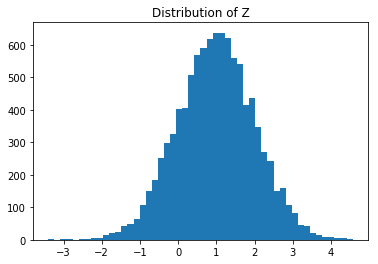

In [16]:
workspace.RunOperatorOnce(op)
temp = workspace.FetchBlob("Z")
pyplot.hist(temp.flatten(), bins=50)
pyplot.title("Distribution of Z")

把tensor 打平看一下分配 
你就看到一個常態1,1的分配, wow~

In [17]:
type(temp)

numpy.ndarray

## Nets

Nets 基本上是個 computation graphs, 我們保留 `Net` 為了跟過去的一致性 (同時也是像 neural net 致敬).

一個Net 是由多個 operator 組成, 就像一個由 序列的 commands組成的程式.

當我們說道net時, 我們通常會順便說一下 BlobReference, 這是個 物件用來將 string 打包, 因此我們可以容易的將operator chain在一起

讓我們做一個簡單的運算如下
```
X = np.random.randn(2, 3)
W = np.random.randn(5, 3)
b = np.ones(5)
Y = X * W^T + b
```
我們會展示如何一步一步做到他

 Caffe2 的 `core.Net` is a wrapper class around a NetDef protocol buffer.


當創造network 的時候, 基本上其底下的 protocol buffer 是空的除了他自己的network name, 讓我們展示個給你看

In [18]:
net = core.Net("my_first_net")
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "my_first_net"



讓我們建立一個blob稱作 X, 且使用 GaussianFill 塞一些隨機數值進去

In [19]:
X = net.GaussianFill([], ["X"], mean=0.0, std=1.0, shape=[2, 3], run_once=0)
print("New network proto:\n\n{}".format(net.Proto()))

New network proto:

name: "my_first_net"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}



你可能已經觀察到一些跟剛才 用`core.CreateOperator` 創op 不同的地方. 

基本上, 當我們有net了 你可以直接創造一個 operator *跟* 將其同時加到 net裡.
透過 python tricks: 當你call `net.SomeOp` 這個 SomeOp 已經是某個op 的 registered type string. 意同於

```
op = core.CreateOperator("SomeOp", ...)
net.Proto().op.append(op)
```

你可能還會好奇 X 這個變數是什麼, 他是個 `BlobReference`  基本上紀錄兩件事
- X的 name, 你可以用str(X)取得
- X 由哪個net 創造, 紀錄於 internal variable `_from_net`, 但基本上你不太會需要這個

讓我們驗證一下, 記住 我們其實什麼都還沒跑, 所以 X 現在什麼都沒有只是個 symbol

在這個當下 不要期待拿到任何的數值:)

In [20]:
print("Type of X is: {}".format(type(X)))
print("The blob name is: {}".format(str(X)))

Type of X is: <class 'caffe2.python.core.BlobReference'>
The blob name is: X


好 讓我們在net中把 W,b 搞出來

In [21]:
W = net.GaussianFill([], ["W"], mean=0.0, std=1.0, shape=[5, 3], run_once=0)
b = net.ConstantFill([], ["b"], shape=[5,], value=1.0, run_once=0)

所以如果我們還需要加額外的operator到net上

現在 介紹個簡單的 蜜糖語法: 因為我們已經知道 BlobReference objects 是來自哪個net了, 你可以用這些 BlobReferences 來創 operators. 

好直接創個FC operator 給你看一下


In [22]:
Y = X.FC([W, b], ["Y"])

這個魔法底下, `X.FC(...)` 其實是將 `X` 塞入 `net.FC` 當第一個 input ,  所以其實我們做的事就是

```
Y = net.FC([X, W, b], ["Y"])
```

好讓我們來好好看一下現在的network長相

In [23]:
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "my_first_net"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "W"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "X"
  input: "W"
  input: "b"
  output: "Y"
  name: ""
  type: "FC"
}



是不是太囉唆了？ 讓我們 把他視覺化成一個 graph. 

Caffe2 提供一個最小化的 graph visualization tool

我們在ipython 裡show他一個

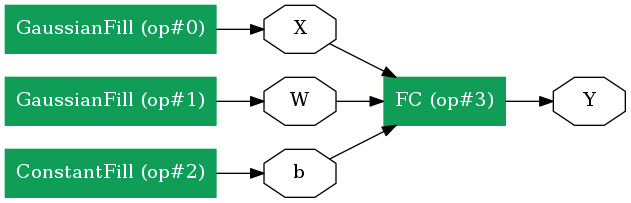

In [24]:
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraph(net, rankdir="LR")
display.Image(graph.create_png(), width=800)

所以我們已經定義了一個 `Net` 但是沒有任何東西被執行. 記住上方的net 基本上只是 個 protobuf 紀錄了 network的 definition. 

當我們實際想要跑這個network的時候, 實際發生的事情是：
- 實例化 一個 C++ net object from protobug;
- 呼叫 已實例化net 的 Run() function

再做任何是之前 我們應該先清空先前 workspace 中的 variables with  `ResetWorkspace()`.

接著那兩有兩種方式用來run net from Python. 我們下面會用第一個option 當作example:
1. 用`workspace.RunNetOnce()`, 建立, 跑, 馬上 desturct network
2. 用稍微麻煩一點的方式, 包含兩步驟:

    (a) call `workspace.CreateNet()` 創造 C++ net 物件, 由workspace 所擁有
    
    (b) 用 `workspace.RunNet()` 並給予 name of the nework

In [26]:
workspace.ResetWorkspace()  # 清空
print("Current blobs in the workspace: {}".format(workspace.Blobs()))  # 現在workspace 裡有啥
workspace.RunNetOnce(net)  # 跑一次
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))  # 跑玩 workspace 裡有啥
# Let's dump the contents of the blobs
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))  # 每一個 show一下

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[-0.76547468 -0.58089137 -0.84373212]
 [ 0.02712025 -0.95473266  1.38141382]
 [ 1.86745214  0.54926169  0.34149343]
 [-0.44601798  0.022399    0.39733365]
 [-3.65019441 -0.38386416 -0.54719496]]
X:
[[ 0.38527066 -0.17687318 -0.26254421]
 [-0.76804817 -0.98803753 -2.1666019 ]]
Y:
[[ 1.02934611  0.81663305  1.53266764  0.71988291 -0.1947546 ]
 [ 3.98989558 -1.07049179 -1.71686459  0.45956838  5.36835098]]
b:
[ 1.  1.  1.  1.  1.]


現在讓我們試第二種創net的方法, 跟跑他, 一樣先把 workspace variable清光 `ResetWorkspace()`, 

接著 創net object with worksapce `CreateNet(net_object)`

跑 net with `RunNet(net_name)`.


In [27]:
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.CreateNet(net)
workspace.RunNet(net.Proto().name)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[-0.10392593  0.36114728 -0.12342339]
 [ 0.14249685 -1.75026572 -1.00734639]
 [ 0.78308648  1.07265329 -1.82039893]
 [ 1.12831903  0.35040882 -0.55579144]
 [ 0.28380862  0.18905655 -0.63279754]]
X:
[[-0.02035939 -1.56992447 -1.11619127]
 [-0.85490125  0.13232879  0.92667669]]
Y:
[[ 0.57290596  4.86927509  1.33198547  1.04728222  1.40374041]
 [ 1.02226305 -0.28691578 -1.21443987 -0.43327117  0.19599056]]
b:
[ 1.  1.  1.  1.  1.]


一些關於 `RunNetOnce` and `RunNet` 的差異

主要的差異應該是 time overhead, 因為 `RunNetOnce` 包含 (序列化) (跟將 protobuf 在 python 與 C 之間傳遞), 還有 (實例化 net)

這可能會久一點, 讓我們看一下時間差異

In [25]:
# It seems that %timeit magic does not work well with
# C++ extensions so we'll basically do for loops
start = time.time()
for i in range(1000):
    workspace.RunNetOnce(net)
end = time.time()
print('Run time per RunNetOnce: {}'.format((end - start) / 1000))

start = time.time()
for i in range(1000):
    workspace.RunNet(net.Proto().name)
end = time.time()
print('Run time per RunNet: {}'.format((end - start) / 1000))

Run time per RunNetOnce: 0.000364284992218
Run time per RunNet: 4.42600250244e-06


OK, 上面已經是少數的關鍵 componets , 如果你想從 python 來使用 Caffe2 我們會增加更多的 tutorial 如果我們發現更多的需求

接著試著看一下其他的tutorial吧